In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
def load_data(main_path, campaign_path, external_path):
    df_main = pd.read_csv(main_path, parse_dates=['Date'], sep=';')
    df_camp = pd.read_csv(campaign_path, parse_dates=['ValidFrom', 'ValidTo'], sep=';')
    df_ext = pd.read_csv(external_path, sep=';')
    df_ext = df_ext.rename(columns={
        'Datum': 'Date',
        'AnonymniProdukt': 'Product',
        'Mnozstvi': 'HistoricalQuantity'
    })
    df_ext['Date'] = pd.to_datetime(df_ext['Date'])
    return df_main, df_camp, df_ext

def merge_campaigns(df, df_camp):
    expanded = (
        df_camp
        .assign(Date=lambda x: [pd.date_range(a, b) for a, b in zip(x['ValidFrom'], x['ValidTo'])])
        .explode('Date')
    )
    expanded = expanded[['Product', 'Country', 'Date']]
    expanded['CampaignActive'] = 1
    df = df.merge(expanded, on=['Product', 'Country', 'Date'], how='left')
    df['CampaignActive'] = df['CampaignActive'].fillna(0).astype(int)
    return df

def merge_external(df, df_ext):
    return df.merge(df_ext, on=['Date', 'Product'], how='left')

In [3]:
def engineer_features(df, lags=[1, 7, 30], rolls=[7, 30]):
    df = df.sort_values('Date')
    # Ensure HistoricalQuantity exists
    if 'HistoricalQuantity' not in df.columns:
        df['HistoricalQuantity'] = 0
    df['year'] = df['Date'].dt.year
    df['week'] = df['Date'].dt.isocalendar().week
    df['month'] = df['Date'].dt.month
    for lag in lags:
        df[f'lag_qty_{lag}'] = df.groupby(['Product', 'Country'])['Quantity'].shift(lag)
        df[f'lag_hist_{lag}'] = df.groupby(['Product', 'Country'])['HistoricalQuantity'].shift(lag)
    for window in rolls:
        df[f'roll_mean_qty_{window}'] = df.groupby(['Product', 'Country'])['Quantity'].transform(lambda x: x.shift(1).rolling(window).mean())
        df[f'roll_mean_hist_{window}'] = df.groupby(['Product', 'Country'])['HistoricalQuantity'].transform(lambda x: x.shift(1).rolling(window).mean())
    df = pd.get_dummies(df, columns=['CountryStatus', 'ProductStatus'], drop_first=True)
    df.fillna(0, inplace=True)
    return df

In [4]:
def split_train_test(df, date_col='Date', test_size=0.2):
    df = df.sort_values(date_col)
    split_idx = int((1 - test_size) * len(df))
    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]
    return train, test, df.iloc[split_idx][date_col]

def train_model(train_df, features, target='Quantity'):
    X_train = train_df[features]
    y_train = train_df[target]
    
    model = RandomForestRegressor(
        n_estimators=100,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1,
        oob_score=False
    )
    model.fit(X_train, y_train)
    return model

def predict(model, test_df, features, target='Quantity'):
    X_test = test_df[features]
    y_test = test_df[target]
    
    test_df['Predicted'] = model.predict(X_test)
    
    # Post-process: set predictions to zero where stock is zero
    test_df.loc[test_df['Stock'] == 0, 'Predicted'] = 0

    # Evaluation
    mae = mean_absolute_error(y_test, test_df['Predicted'])
    rmse = np.sqrt(mean_squared_error(y_test, test_df['Predicted']))
    r2 = r2_score(y_test, test_df['Predicted'])
    
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.3f}")
    
    return pd.Series(test_df['Predicted'].values, index=test_df['Date']), test_df

In [5]:
def train_and_predict(train, test, feature_cols, target_col='Quantity'):
    X_train, y_train = train[feature_cols], train[target_col]
    X_test, y_test = test[feature_cols], test[target_col]
    model = RandomForestRegressor(
        n_estimators=100,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1,
        oob_score=False
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse     = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.3f}")
    return pd.Series(preds, index=test['Date']), test, model

In [6]:
def plot_forecast(original, preds, split_date, title):
    plt.figure(figsize=(12,6), facecolor='#242424')
    plt.plot(original.index, original.values, label='Train+Test', color = '#fefefe')
    plt.plot(preds.index, preds.values, label='Predicted', linestyle='--', color = "red")
    plt.axvline(split_date, color='blue', linestyle=':')

    ax = plt.gca()
    ax.set_facecolor('#242424')
    ax.tick_params(axis='x', colors='#fefefe')
    ax.tick_params(axis='y', colors='#fefefe')
    ax.spines['bottom'].set_color('#fefefe')
    ax.spines['top'].set_color('#fefefe')
    ax.spines['right'].set_color('#fefefe')
    ax.spines['left'].set_color('#fefefe')
    plt.title(title, color='#fefefe')
    plt.xlabel('Date', color='#fefefe')
    plt.ylabel('Quantity', color='#fefefe')
    plt.legend(labelcolor='#fefefe', facecolor='#242424')
    plt.grid(False)
    plt.show()

In [7]:
def method_country(df_full):
    for country, grp in df_full.groupby('Country'):
        daily = grp.set_index('Date').resample('W')['Quantity'].sum().reset_index()
        df_feat = daily.rename(columns={'Quantity': 'Quantity', 'Date': 'Date'})
        df_feat['Product'], df_feat['Country'] = 'ALL', country
        df_feat['CountryStatus'], df_feat['ProductStatus'] = 'A', 'A'
        if 'HistoricalQuantity' not in df_feat.columns:
            df_feat['HistoricalQuantity'] = 0
        df_feat = engineer_features(df_feat)
        train, test, split_date = split_train_test(df_feat)
        feats = [c for c in train.columns if c not in ['Date','Quantity','Product','Country','HistoricalQuantity']]
        preds, test_df, _ = train_and_predict(train, test, feats)
        plot_forecast(daily.set_index('Date')['Quantity'], preds, split_date,
                      f'Country Forecast: {country}')

def method_global(df_full):
    daily = df_full.set_index('Date').resample('W')['Quantity'].sum().reset_index()
    daily['Product'], daily['Country'] = 'ALL', 'ALL'
    daily['CountryStatus'], daily['ProductStatus'] = 'A', 'A'
    if 'HistoricalQuantity' not in daily.columns:
        daily['HistoricalQuantity'] = 0
    df_feat = engineer_features(daily)
    train, test, split_date = split_train_test(df_feat)
    feats = [c for c in train.columns if c not in ['Date','Quantity','Product','Country','HistoricalQuantity']]
    preds, test_df, _ = train_and_predict(train, test, feats)
    plot_forecast(daily.set_index('Date')['Quantity'], preds, split_date,
                  'Global Sales Forecast')

def method_status(df_full):
    for cs in ['A','Z']:
        for ps in ['A','Z']:
            sub = df_full[(df_full.CountryStatus == cs) & (df_full.ProductStatus == ps)]
            if sub.empty:
                continue
            daily = sub.set_index('Date').resample('W')['Quantity'].sum().reset_index()
            daily['CountryStatus'], daily['ProductStatus'] = cs, ps
            daily['Product'], daily['Country'] = 'ALL', 'ALL'
            if 'HistoricalQuantity' not in daily.columns:
                daily['HistoricalQuantity'] = 0
            df_feat = engineer_features(daily)
            train, test, split_date = split_train_test(df_feat)
            feats = [c for c in train.columns if c not in ['Date','Quantity','Product','Country','HistoricalQuantity']]
            preds, test_df, _ = train_and_predict(train, test, feats)
            plot_forecast(daily.set_index('Date')['Quantity'], preds, split_date,
                          f'Status {cs}{ps}')


MAE: 4691.13, RMSE: 6985.99, R2: 0.579


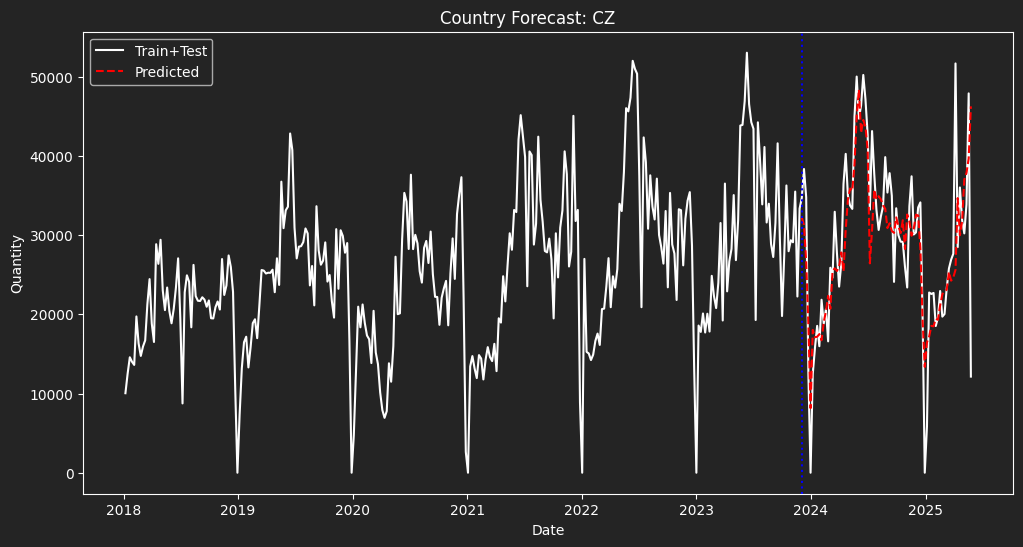

MAE: 7173.20, RMSE: 10621.07, R2: 0.560


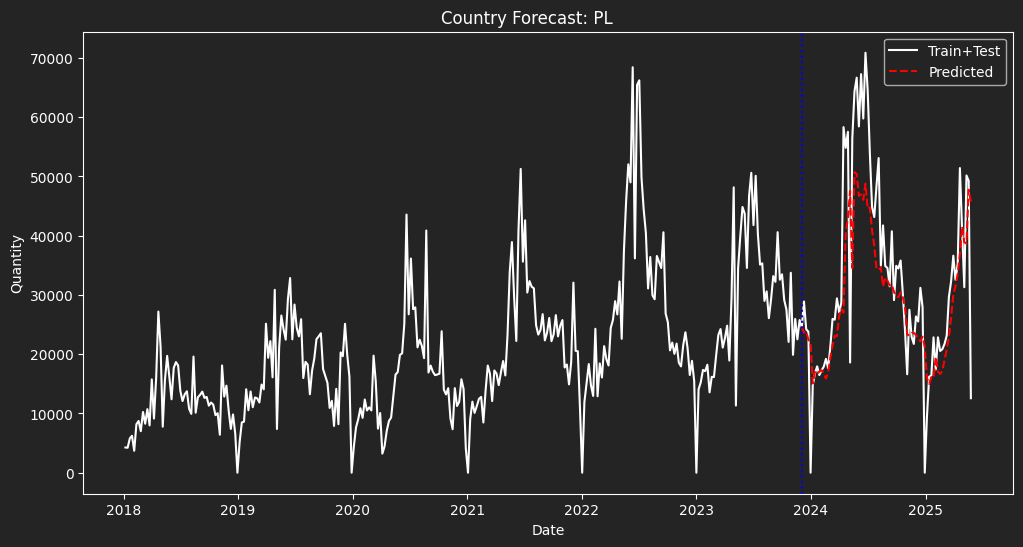

MAE: 10938.95, RMSE: 15279.13, R2: 0.641


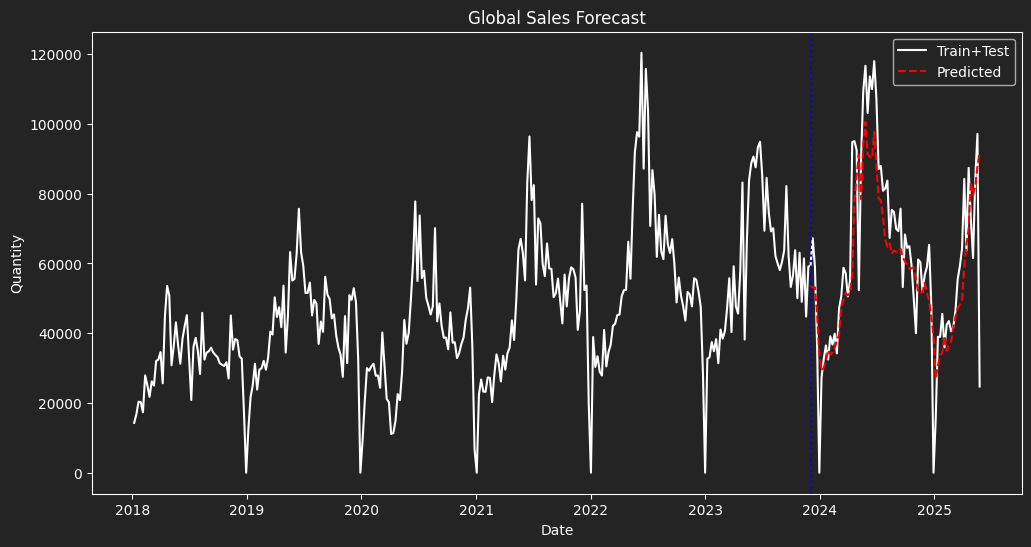

MAE: 10938.95, RMSE: 15279.13, R2: 0.641


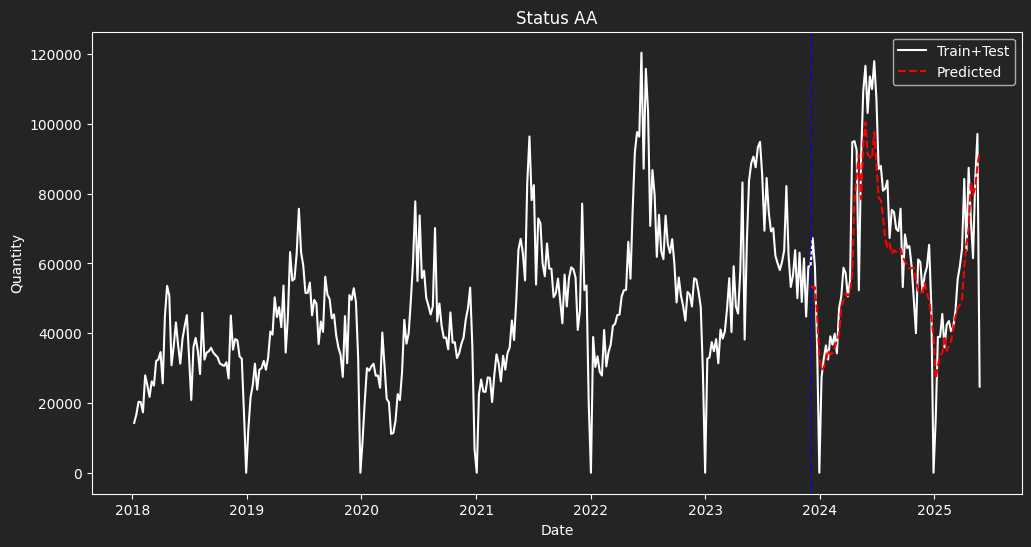

MAE: 4740.32, RMSE: 7170.19, R2: 0.557


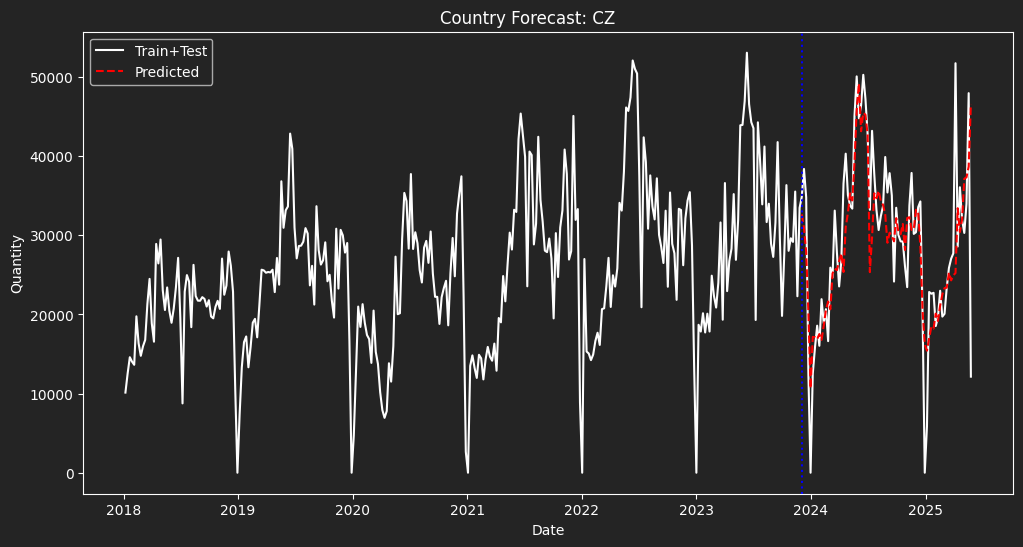

MAE: 474.21, RMSE: 717.33, R2: -0.264


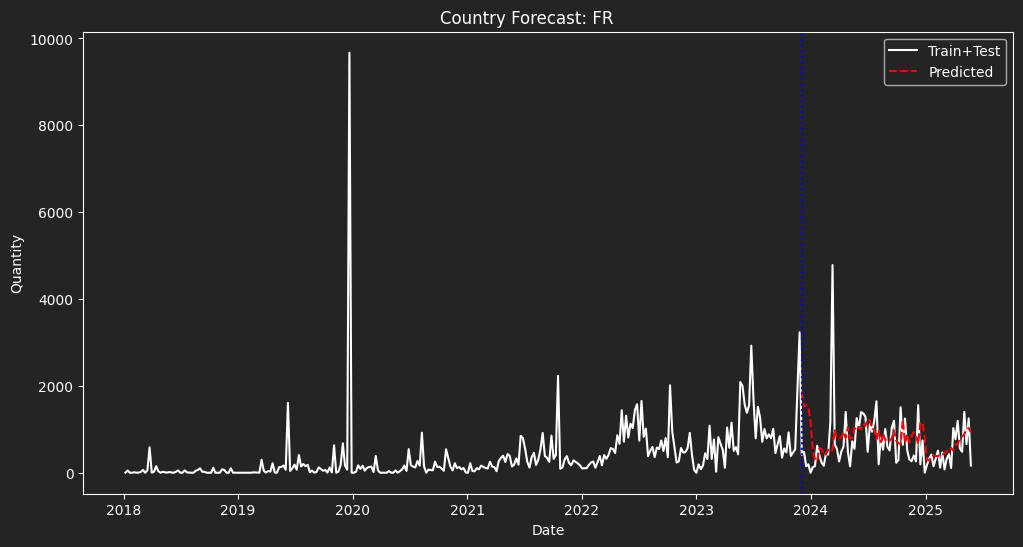

MAE: 1225.67, RMSE: 2055.51, R2: 0.331


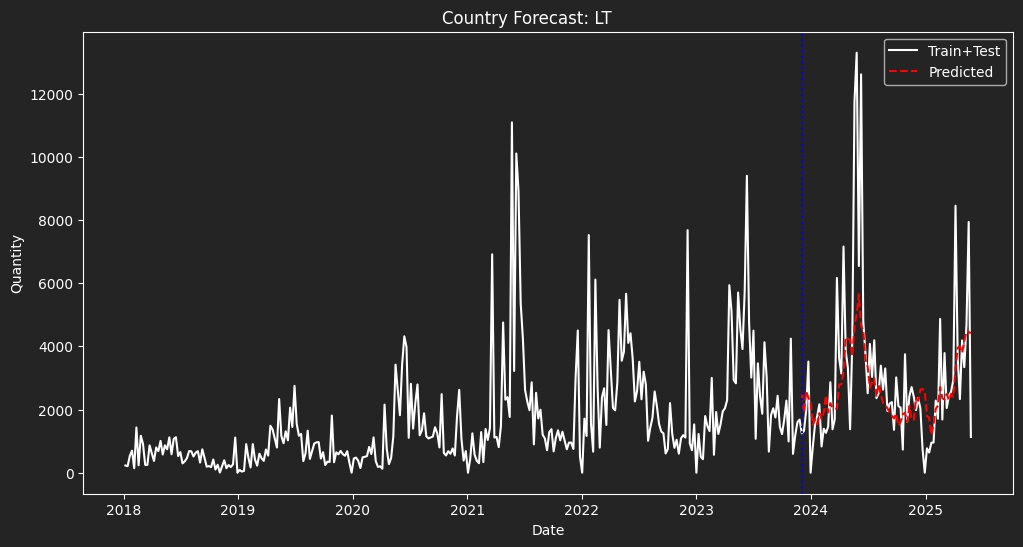

MAE: 7304.74, RMSE: 10667.33, R2: 0.557


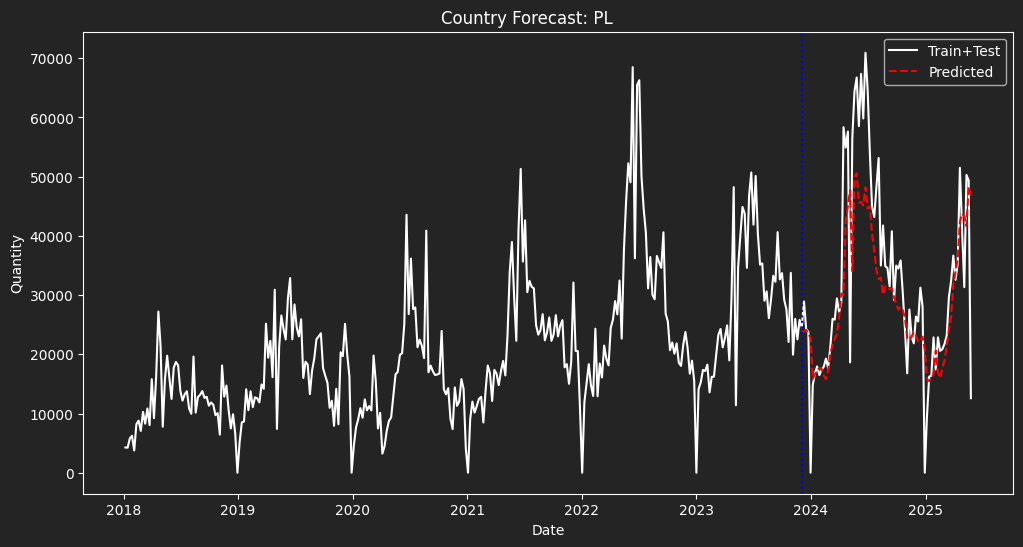

MAE: 12212.74, RMSE: 17170.05, R2: 0.612


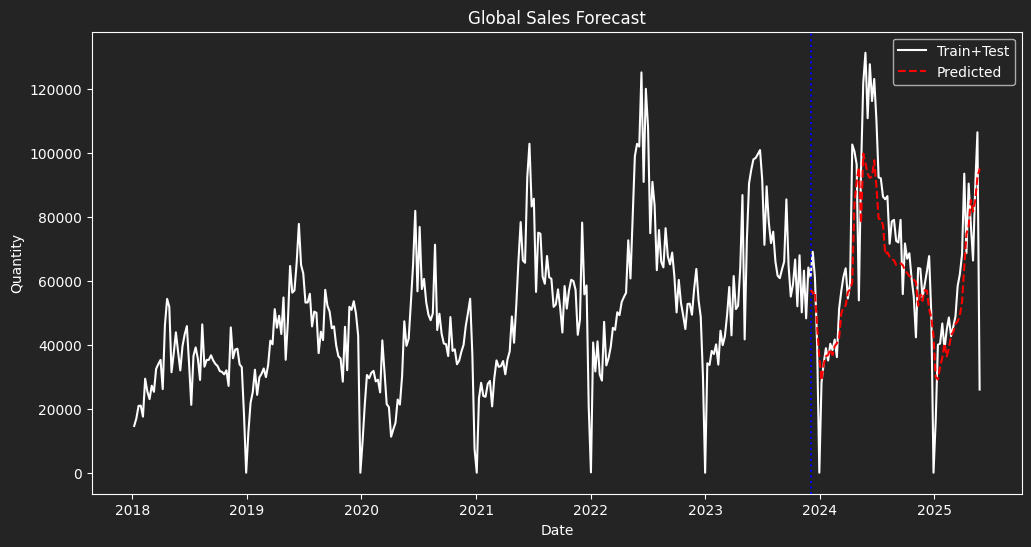

MAE: 10938.95, RMSE: 15279.13, R2: 0.641


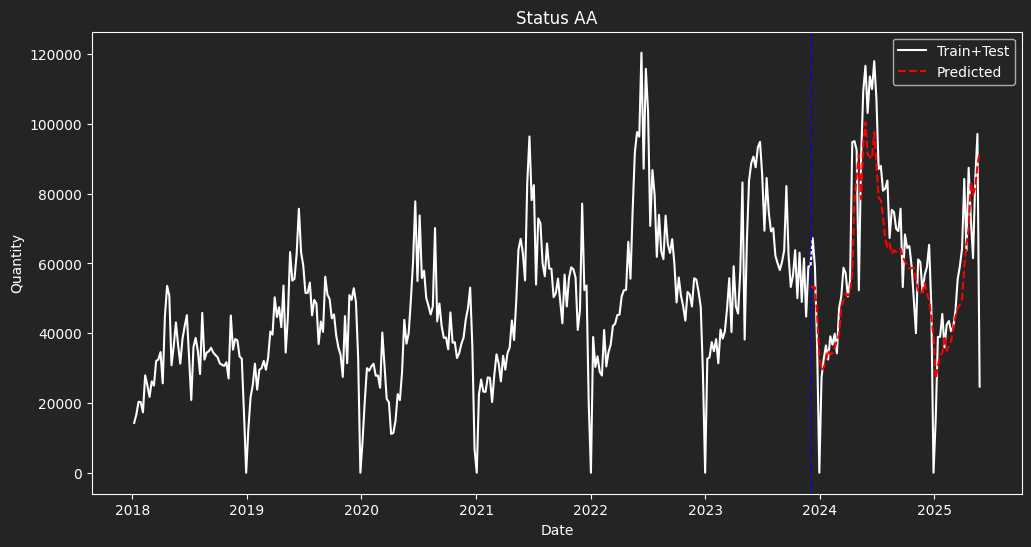

MAE: 49.16, RMSE: 69.46, R2: 0.143


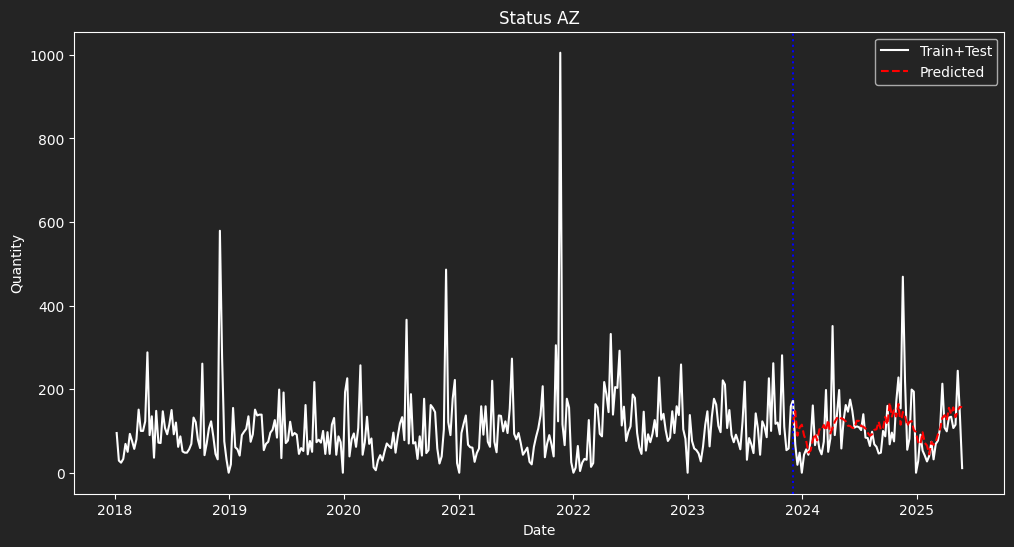

MAE: 1418.86, RMSE: 2162.62, R2: 0.371


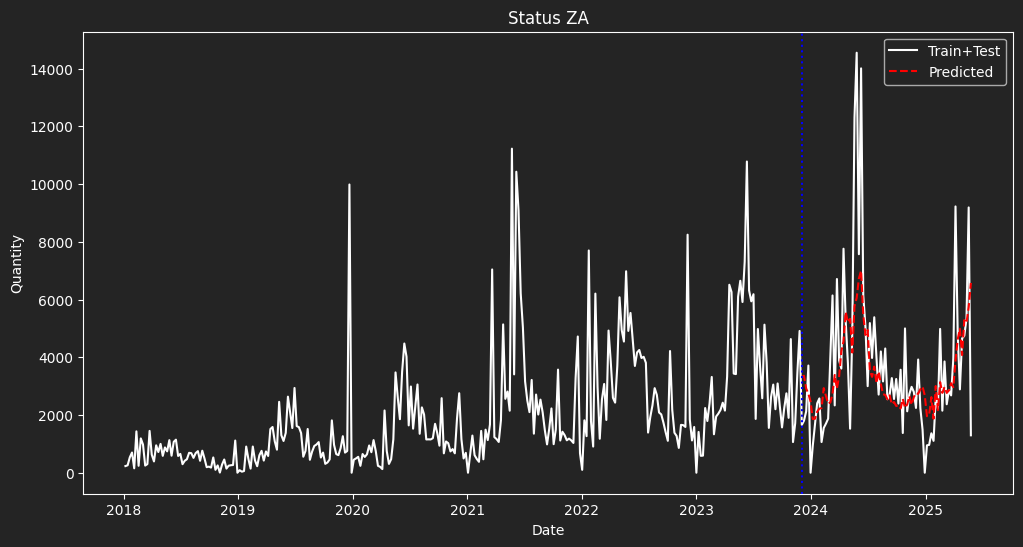

MAE: 5.94, RMSE: 6.89, R2: -1.647


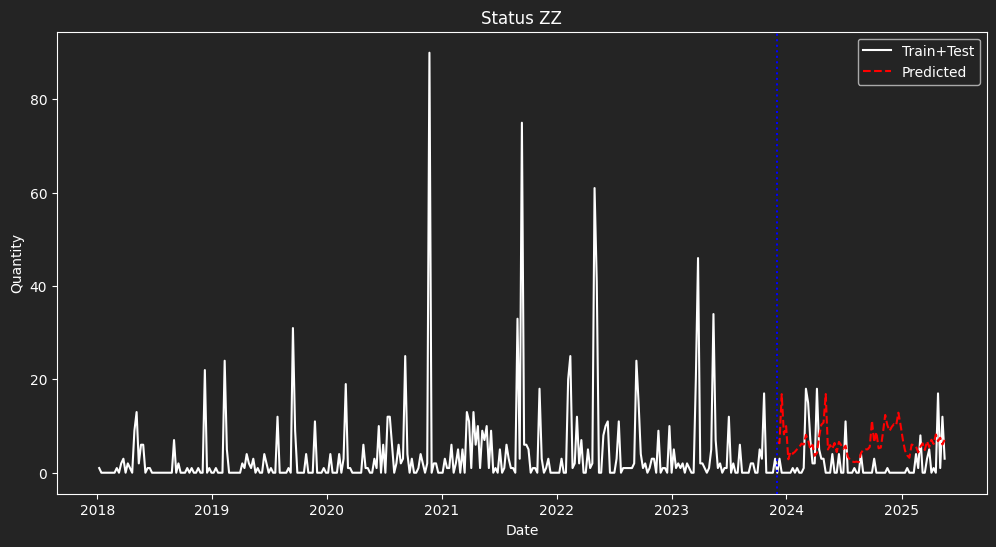

In [8]:
main_path = './data/sell_data_cleaned.csv'
campaign_path = './data/marketing_campaign.csv'
external_path = './data/stock.csv'
df_main, df_camp, df_ext = load_data(main_path, campaign_path, external_path)
df = merge_campaigns(df_main, df_camp)
df = merge_external(df, df_ext)
df = df[df['Quantity'] > 0]
df_AA = df[(df.CountryStatus == 'A') & (df.ProductStatus == 'A')]
method_country(df_AA)
method_global(df_AA)
method_status(df_AA)
method_country(df)
method_global(df)
method_status(df)